In [5]:
from Model import Classifier
from Model import get_device
from Model import Model
import torch
import torch.nn as nn
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt



Using GPU: Tesla V100-SXM2-32GB


/tmp/ipykernel_3650253/4289071352.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(path_to_model, map_location=device))


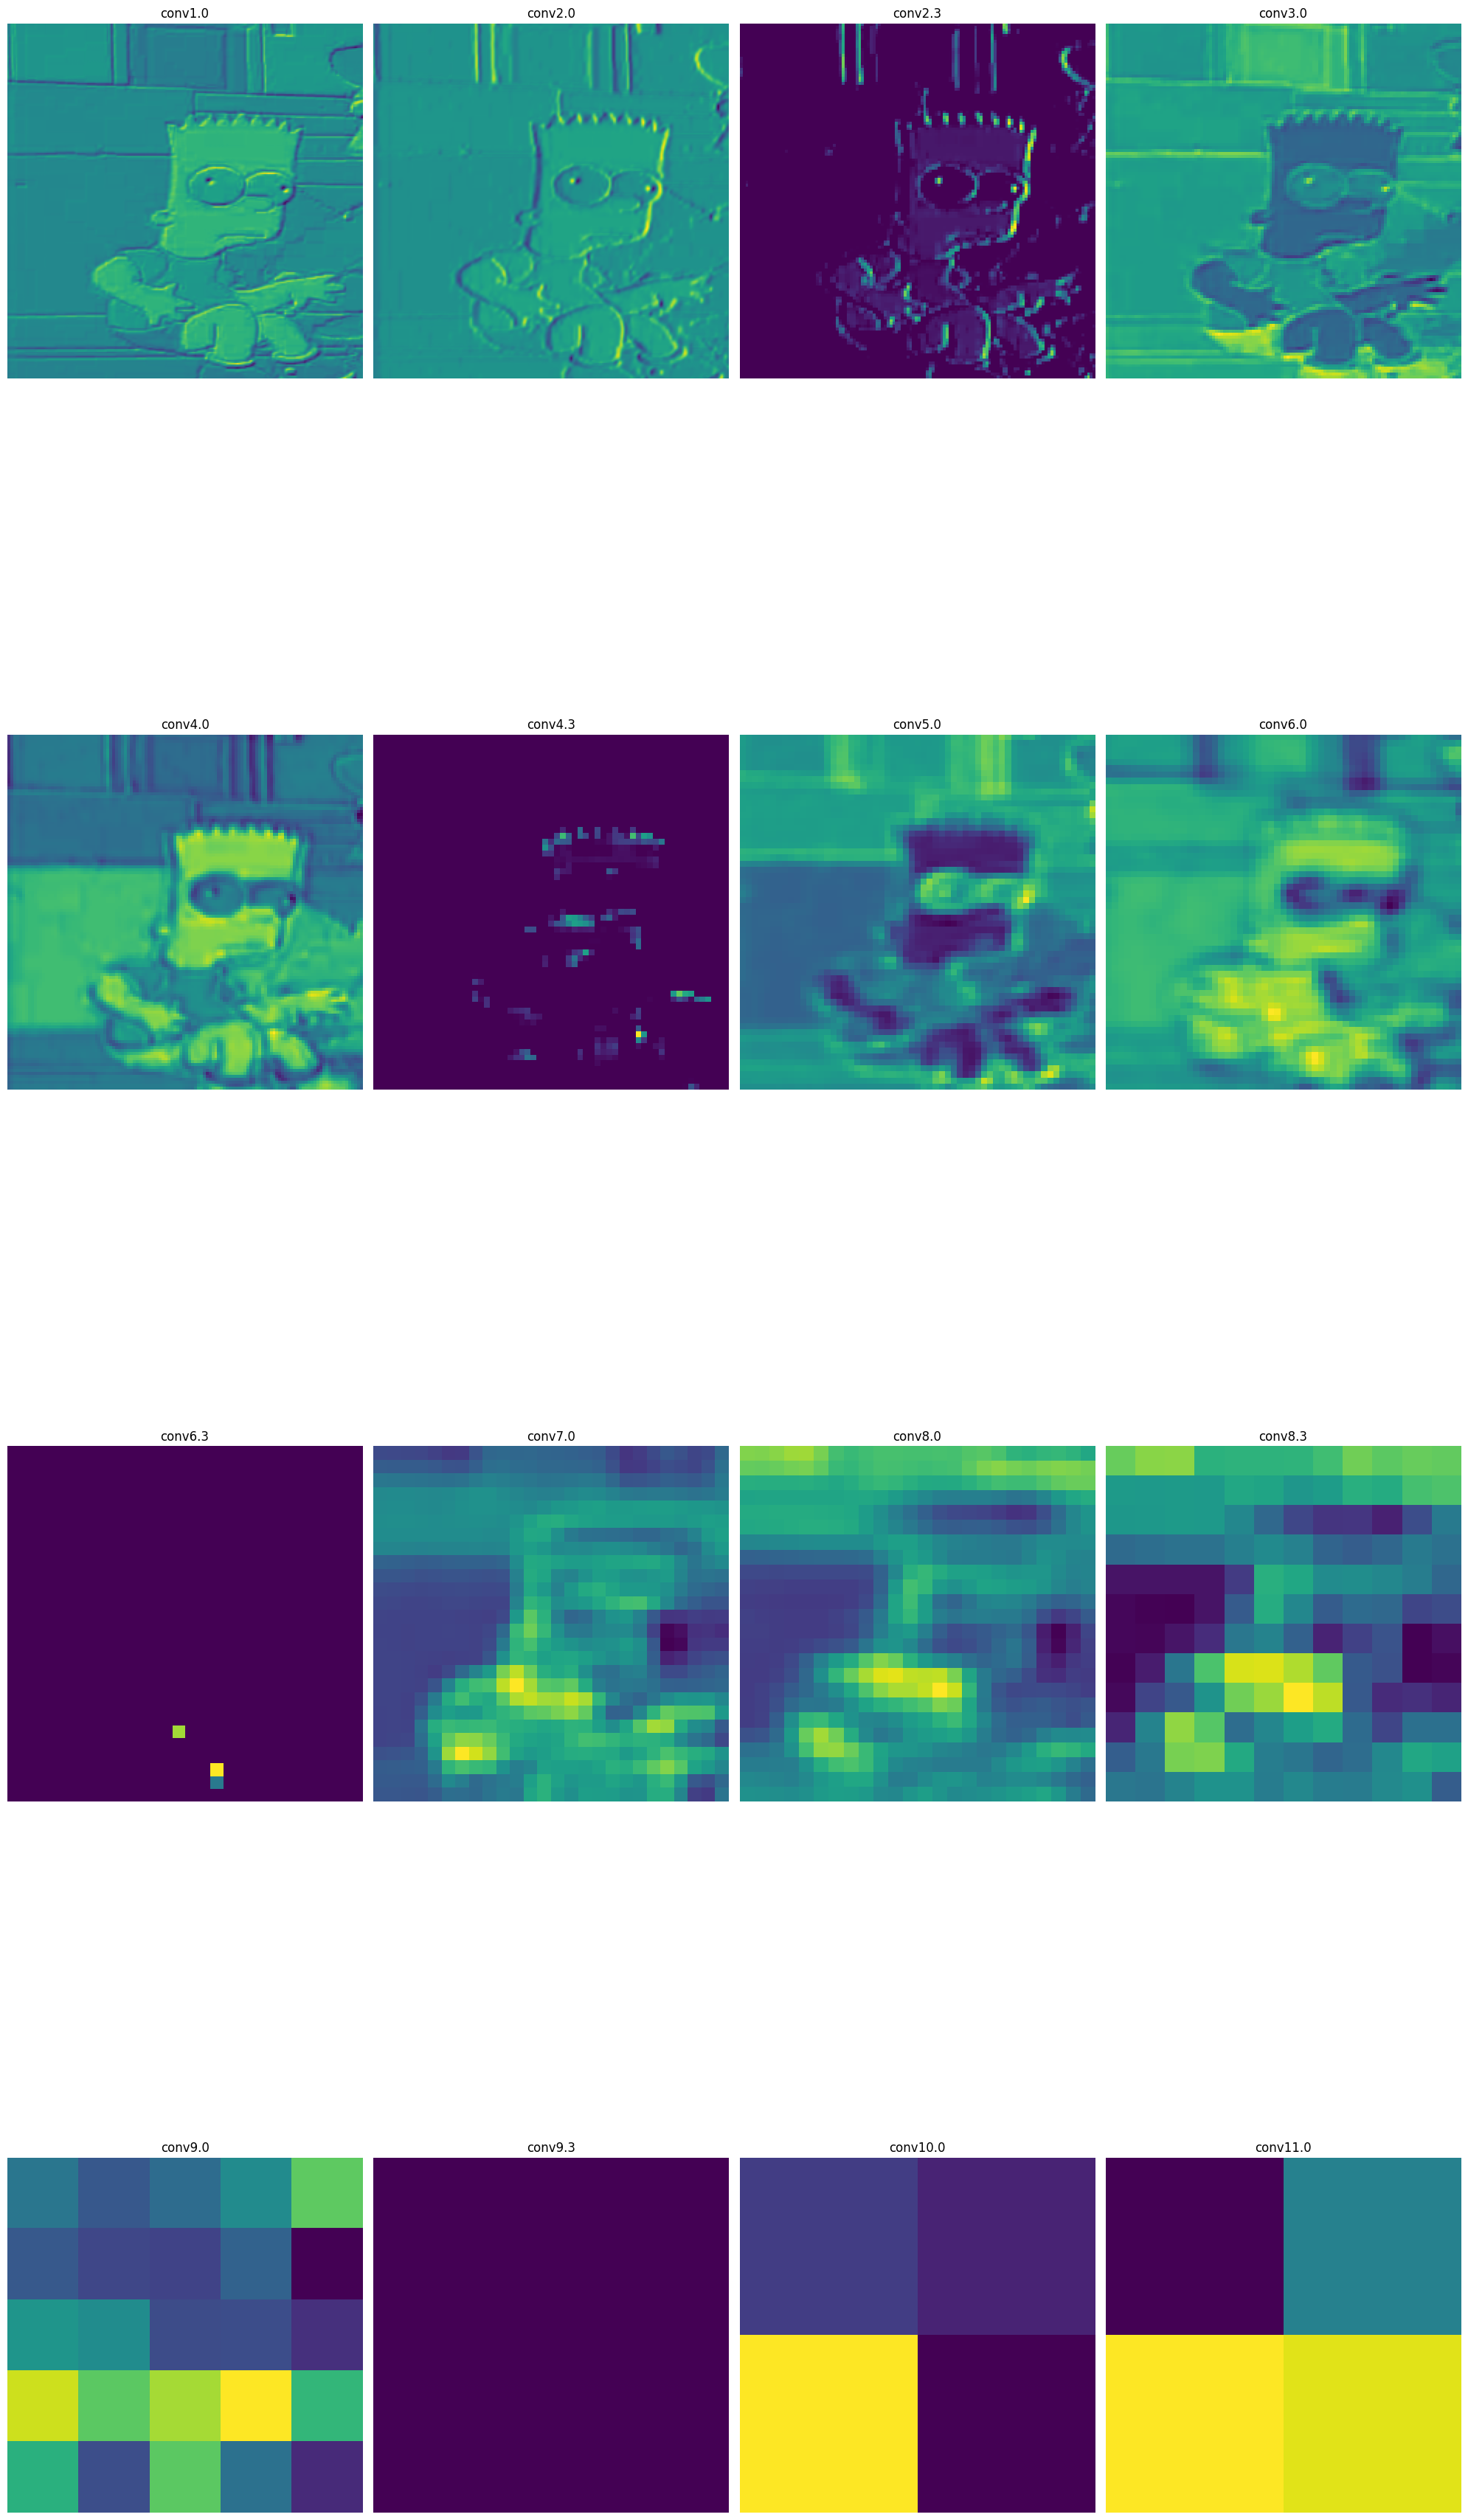

In [6]:
device = get_device()
model = Model().to(device)

path_to_model = '/home/i.karakulin/Classification-of-the-Simpsons/meta_data/2.tar'
path_to_test = '/home/i.karakulin/Classification-of-the-Simpsons/dataset/testset'

model.load_state_dict(torch.load(path_to_model, map_location=device))
model.eval()

# 2. Подготовка изображения
def preprocess_image(image_path):
    transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
    ])
    img = Image.open(image_path).convert('RGB')
    return transform(img).unsqueeze(0).to(device)

# 3. Регистрация хуков
activations = {}

def get_activation(name):
    def hook(model, input, output):
        activations[name] = output.detach()
    return hook

# Регистрируем хуки для всех важных слоев
hooks = []
for name, layer in model.named_modules():
    if isinstance(layer, (nn.Conv2d, nn.MaxPool2d, nn.Linear)):
        hook = layer.register_forward_hook(get_activation(name))
        hooks.append(hook)

# 4. Запуск и визуализация
def visualize_activations(image_path, num_cols=4):
    img_tensor = preprocess_image(image_path)
    
    with torch.no_grad():
        output = model(img_tensor)
    
    # Собираем все активации
    layer_names = list(activations.keys())
    
    # Визуализация
    plt.figure(figsize=(20, 50))
    for i, (name, activation) in enumerate(activations.items()):
        plt.subplot(len(activations)//num_cols + 1, num_cols, i+1)
        
        # Для сверточных слоев: показываем первый канал
        if len(activation.shape) == 4:
            act = activation[0, 0].cpu().numpy()
        # Для Linear-слоев: преобразуем в 2D
        elif len(activation.shape) == 2:
            act = activation[0].cpu().numpy().reshape(1, -1)
        else:
            continue
            
        plt.imshow(act, cmap='viridis')
        plt.title(name)
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# 5. Пример использования
path_to_test_image = '/home/i.karakulin/Classification-of-the-Simpsons/dataset/train/bart_simpson/pic_0009.jpg'
visualize_activations(path_to_test_image)

# 6. Удаление хуков (важно!)
for hook in hooks:
    hook.remove()


In [3]:
class ModelWithHooks(nn.Module):
    def __init__(self, original_model):
        super().__init__()
        self.layers = []
        
        # Распаковываем все Sequential-блоки
        for name, layer in original_model.named_children():
            if isinstance(layer, nn.Sequential):
                for subname, sublayer in layer.named_children():
                    self.layers.append(sublayer)
            else:
                self.layers.append(layer)
                
        # Регистрируем хуки
        self.outputs = {}
        for idx, layer in enumerate(self.layers):
            layer.register_forward_hook(
                lambda module, input, output, idx=idx: self.outputs.update({idx: output})
            )

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x


In [4]:
model_hooked = ModelWithHooks(model).to(device)
model_hooked.load_state_dict(torch.load(path_to_model, map_location=device))
model_hooked.eval()

/tmp/ipykernel_3650253/2105007461.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_hooked.load_state_dict(torch.load(path_to_model, map_location=device))


RuntimeError: Error(s) in loading state_dict for ModelWithHooks:
	Unexpected key(s) in state_dict: "conv1.0.weight", "conv1.0.bias", "conv1.1.weight", "conv1.1.bias", "conv1.1.running_mean", "conv1.1.running_var", "conv1.1.num_batches_tracked", "conv2.0.weight", "conv2.0.bias", "conv2.1.weight", "conv2.1.bias", "conv2.1.running_mean", "conv2.1.running_var", "conv2.1.num_batches_tracked", "conv3.0.weight", "conv3.0.bias", "conv3.1.weight", "conv3.1.bias", "conv3.1.running_mean", "conv3.1.running_var", "conv3.1.num_batches_tracked", "conv4.0.weight", "conv4.0.bias", "conv4.1.weight", "conv4.1.bias", "conv4.1.running_mean", "conv4.1.running_var", "conv4.1.num_batches_tracked", "conv5.0.weight", "conv5.0.bias", "conv5.1.weight", "conv5.1.bias", "conv5.1.running_mean", "conv5.1.running_var", "conv5.1.num_batches_tracked", "conv6.0.weight", "conv6.0.bias", "conv6.1.weight", "conv6.1.bias", "conv6.1.running_mean", "conv6.1.running_var", "conv6.1.num_batches_tracked", "conv7.0.weight", "conv7.0.bias", "conv7.1.weight", "conv7.1.bias", "conv7.1.running_mean", "conv7.1.running_var", "conv7.1.num_batches_tracked", "conv8.0.weight", "conv8.0.bias", "conv8.1.weight", "conv8.1.bias", "conv8.1.running_mean", "conv8.1.running_var", "conv8.1.num_batches_tracked", "conv9.0.weight", "conv9.0.bias", "conv9.1.weight", "conv9.1.bias", "conv9.1.running_mean", "conv9.1.running_var", "conv9.1.num_batches_tracked", "conv10.0.weight", "conv10.0.bias", "conv10.1.weight", "conv10.1.bias", "conv10.1.running_mean", "conv10.1.running_var", "conv10.1.num_batches_tracked", "conv11.0.weight", "conv11.0.bias". 

In [ ]:
def load_image(path):
    image = Image.open(path)
    image.load()
    
    if image.mode in ('RGBA', 'LA', 'P'):
        image = image.convert('RGB')
    
    return image, image.size

In [ ]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

x, size = load_image(f'{train_dir}/abraham_grampa_simpson/pic_0100.jpg')

img_tensor = transform(img).unsqueeze(0).to(device)  # Shape: [1, 3, 256, 256]